<a href="https://colab.research.google.com/github/lonecoder93/Malaria-Detection/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 99% 668M/675M [00:05<00:00, 198MB/s]
100% 675M/675M [00:05<00:00, 140MB/s]


In [3]:
# Downloaded folder is zipped, Let's unzip it
import zipfile
zip_ref = zipfile.ZipFile('/content/cell-images-for-detecting-malaria.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
# cell_images folder contains a duplicate folder
# Deleting the duplicate folder
import shutil
import os

main_folder_path = "/content/cell_images"

unwanted_folder_path = os.path.join(main_folder_path, "cell_images")

# Check if the unwanted subfolder exists and delete it
if os.path.exists(unwanted_folder_path):
    shutil.rmtree(unwanted_folder_path)
    print(f"Deleted the folder: {unwanted_folder_path}")
else:
    print(f"The folder does not exist: {unwanted_folder_path}")

Deleted the folder: /content/cell_images/cell_images


Parasitized images:


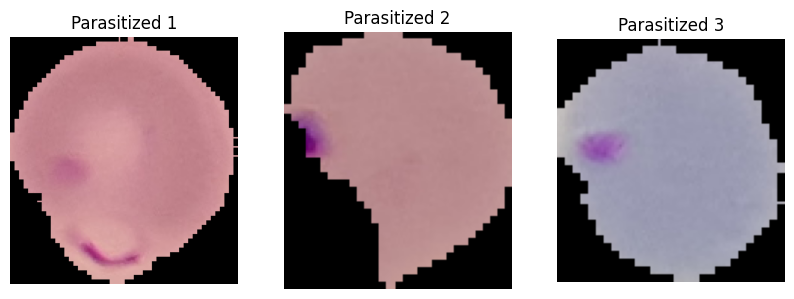

Uninfected images:


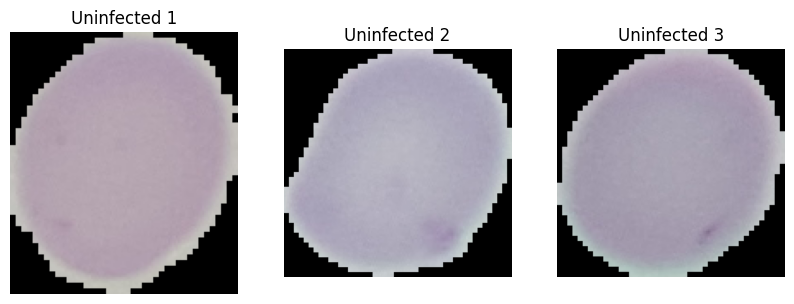

In [5]:
# Visualizing the data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define paths
parasitized_folder = "/content/cell_images/Parasitized"
uninfected_folder = "/content/cell_images/Uninfected"

# Function to display images
def display_images(category_folder, category_name, num_images=3):
    files = os.listdir(category_folder)
    selected_files = files[:num_images]

    plt.figure(figsize=(10, 10))

    for i, file in enumerate(selected_files):
        img_path = os.path.join(category_folder, file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{category_name} {i + 1}")
        plt.axis('off')

    plt.show()

# Display images
print("Parasitized images:")
display_images(parasitized_folder, "Parasitized")

print("Uninfected images:")
display_images(uninfected_folder, "Uninfected")

- From above its is clear that parasitized cells have dark color spots called Schuffner’s dots in its cytoplasm.
- while uninfected cells have a clear cytoplasm.
- Therefore we need to construct ML model which could accurately identify these differences.

In [7]:
# Train Test Split
from sklearn.model_selection import train_test_split

# Define paths
main_folder_path = "/content/cell_images"
output_folder_path = "/content/Malaria"

# Create the output directory structure
os.makedirs(os.path.join(output_folder_path, "train", "Parasitized"), exist_ok=True)
os.makedirs(os.path.join(output_folder_path, "train", "Uninfected"), exist_ok=True)
os.makedirs(os.path.join(output_folder_path, "test", "Parasitized"), exist_ok=True)
os.makedirs(os.path.join(output_folder_path, "test", "Uninfected"), exist_ok=True)

# Function to split and copy files
def split_and_copy_files(category):
    category_path = os.path.join(main_folder_path, category)
    files = os.listdir(category_path)

    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_folder_path, "train", category))

    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_folder_path, "test", category))

# Split and copy files for both categories
split_and_copy_files("Parasitized")
split_and_copy_files("Uninfected")

In [8]:
# Import libraries for building CNN model
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

In [9]:
# Preprocessing the train and validation data
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Malaria/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Malaria/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 22046 files belonging to 2 classes.
Found 5512 files belonging to 2 classes.


In [10]:
# The above images are stored in the numpy array format.
# But, the problem is the value of numpy array rangesfrom 0 to 255. We have to convert this to the format 0 to 1
# Hence, We need to normalize. We are doing this operation to have the values of pixels between 0 to 1
def process(image,label):
  image = tf.cast(image/255. , tf.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [11]:
# Creating CNN Model
# The architecture will consist of three convolutional layers
# First layer would have 32 filters
# Second layer would have 64 filters
# Third layer would have 128 filters

model = Sequential()

# First layer
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

# Second layer
model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

# Third Layer
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

#Flattning
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # 1 since there is only 1 output

In [12]:
# Checking model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [13]:
# Compliling the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
# Executing the model
model_exe = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
689/689 [==============================] - 65s 82ms/step - loss: 0.3557 - accuracy: 0.8367 - val_loss: 0.1794 - val_accuracy: 0.9454
Epoch 2/10
689/689 [==============================] - 52s 75ms/step - loss: 0.1961 - accuracy: 0.9379 - val_loss: 0.1860 - val_accuracy: 0.9396
Epoch 3/10
689/689 [==============================] - 53s 77ms/step - loss: 0.1521 - accuracy: 0.9503 - val_loss: 0.1515 - val_accuracy: 0.9548
Epoch 4/10
689/689 [==============================] - 54s 77ms/step - loss: 0.1151 - accuracy: 0.9620 - val_loss: 0.1621 - val_accuracy: 0.9536
Epoch 5/10
689/689 [==============================] - 56s 81ms/step - loss: 0.0866 - accuracy: 0.9709 - val_loss: 0.1706 - val_accuracy: 0.9577
Epoch 6/10
689/689 [==============================] - 54s 77ms/step - loss: 0.0619 - accuracy: 0.9795 - val_loss: 0.1929 - val_accuracy: 0.9554
Epoch 7/10
689/689 [==============================] - 57s 83ms/step - loss: 0.0490 - accuracy: 0.9847 - val_loss: 0.2251 - val_accuracy:

In [15]:
# Save the model
model.save('/content/malaria_cnn_model_rev0.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


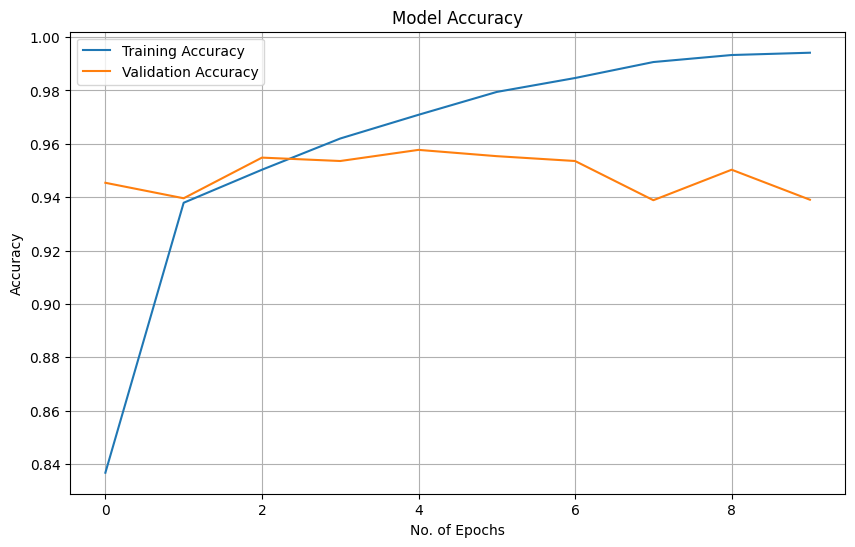

In [20]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(model_exe.history['accuracy'], label='Training Accuracy')
plt.plot(model_exe.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

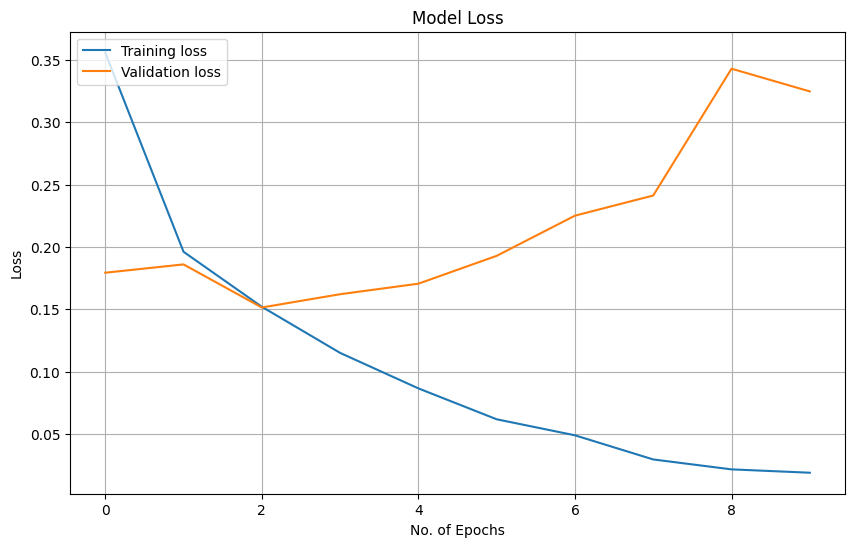

In [22]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(model_exe.history['loss'], label='Training loss')
plt.plot(model_exe.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 87ms/step


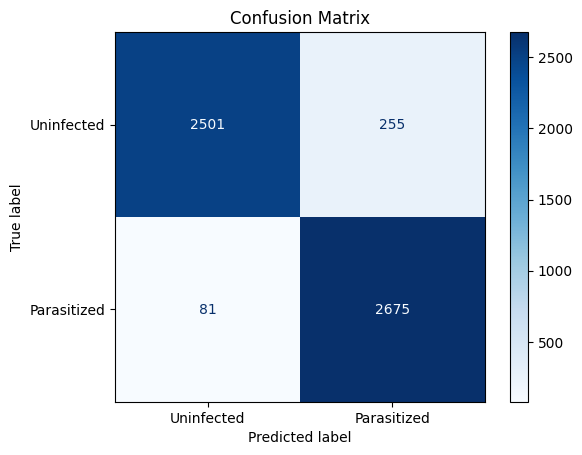

In [23]:
# Load the model
model = keras.models.load_model('/content/malaria_cnn_model_rev0.h5')

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
true_labels = []
predictions = []

for images, labels in validation_ds:
    preds = model.predict(images)
    predictions.extend(preds)
    true_labels.extend(labels.numpy())

# Convert predictions to binary (0 or 1)
predictions = np.array(predictions) > 0.5
predictions = predictions.astype(int).flatten()

# Convert true labels to binary (0 or 1)
true_labels = np.array(true_labels).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Uninfected', 'Parasitized'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

- From above plots it is clear that model is approximately 99% accuracy on training dataset and nearly 94% accuracy on validation dataset
- As the number of epochs increase loss in training reduces but loss for validation increases.
- From confusion matrix it is clear that the model is accurately predicting 94% of the data correctly.
- Lets try to reduce those false negatives and false positives further.
- we will try normalisation and dropout to increase the accuracy of the model and reduce loss in validation.

In [25]:
from keras.layers import BatchNormalization,Dropout

# Recreating CNN Model


model = Sequential()

# First layer
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

# Second layer
model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

# Third Layer
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

#Flattning
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid')) # 1 since there is only 1 output

In [27]:
# Rechecking model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                      

In [28]:
# Compliling the model again
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [29]:
# Executing the model
model_exe = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
689/689 [==============================] - 76s 102ms/step - loss: 0.9470 - accuracy: 0.6269 - val_loss: 0.6222 - val_accuracy: 0.6509
Epoch 2/10
689/689 [==============================] - 70s 101ms/step - loss: 0.4515 - accuracy: 0.8036 - val_loss: 0.2333 - val_accuracy: 0.9307
Epoch 3/10
689/689 [==============================] - 69s 99ms/step - loss: 0.2441 - accuracy: 0.9146 - val_loss: 9.3652 - val_accuracy: 0.4998
Epoch 4/10
689/689 [==============================] - 73s 105ms/step - loss: 0.2214 - accuracy: 0.9239 - val_loss: 1.6289 - val_accuracy: 0.5132
Epoch 5/10
689/689 [==============================] - 72s 104ms/step - loss: 0.1743 - accuracy: 0.9389 - val_loss: 0.1586 - val_accuracy: 0.9441
Epoch 6/10
689/689 [==============================] - 72s 103ms/step - loss: 0.1577 - accuracy: 0.9477 - val_loss: 0.2019 - val_accuracy: 0.9242
Epoch 7/10
689/689 [==============================] - 68s 98ms/step - loss: 0.1458 - accuracy: 0.9520 - val_loss: 0.1849 - val_accu

In [30]:
# Save the new model
model.save('/content/malaria_cnn_model_rev1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


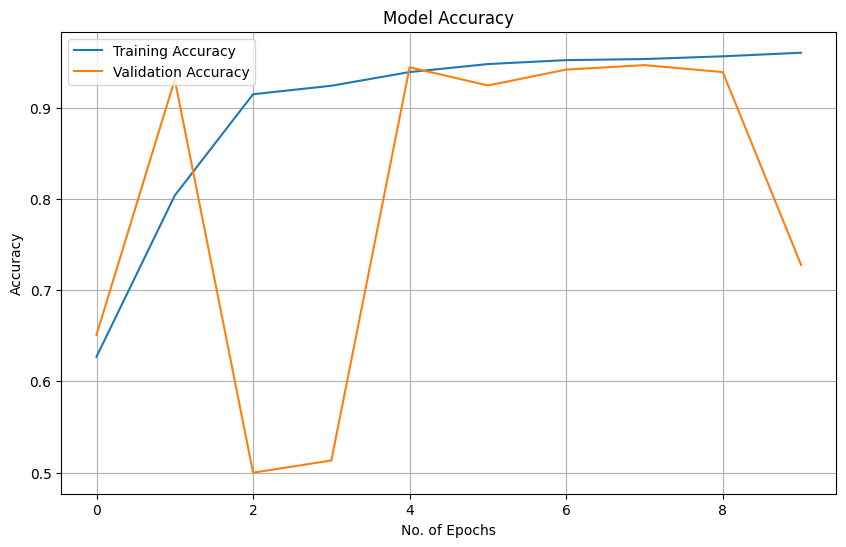

In [31]:
# Plot training & validation accuracy for newly trained model
plt.figure(figsize=(10, 6))
plt.plot(model_exe.history['accuracy'], label='Training Accuracy')
plt.plot(model_exe.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

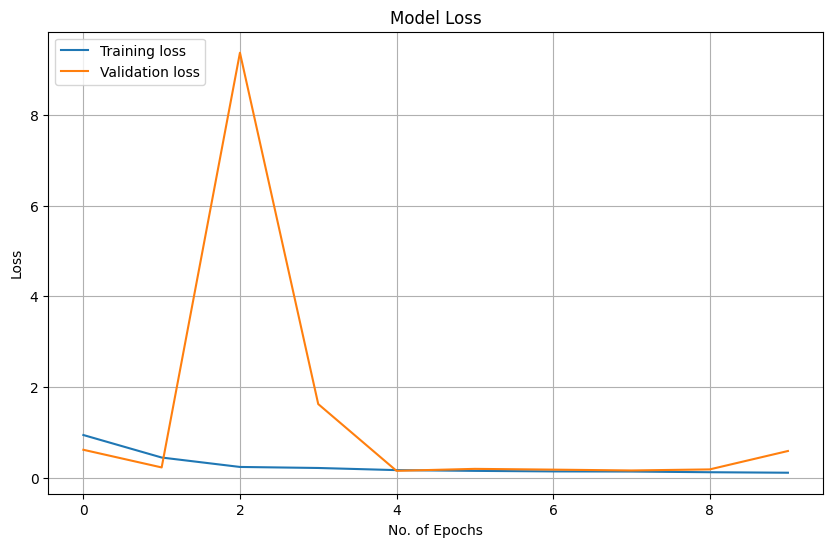

In [33]:
# Plot training & validation loss values for newly trained model
plt.figure(figsize=(10, 6))
plt.plot(model_exe.history['loss'], label='Training loss')
plt.plot(model_exe.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 101ms/step


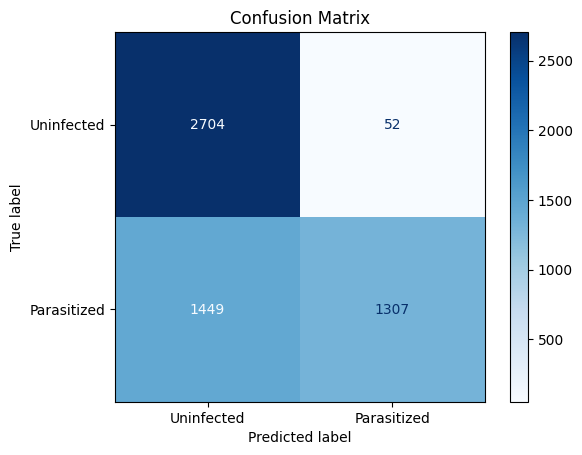

In [34]:
# Load the recently saved model
model = keras.models.load_model('/content/malaria_cnn_model_rev1.h5')


# Plot confusion matrix
true_labels = []
predictions = []

for images, labels in validation_ds:
    preds = model.predict(images)
    predictions.extend(preds)
    true_labels.extend(labels.numpy())

# Convert predictions to binary (0 or 1)
predictions = np.array(predictions) > 0.5
predictions = predictions.astype(int).flatten()

# Convert true labels to binary (0 or 1)
true_labels = np.array(true_labels).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Uninfected', 'Parasitized'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

- From above plots and confusion matrix we can conclude that batch normalization and dropout is reducing the performance of the model.
- While the model has less loss for training and validation as number of epochs increase the accuracy on validation dataset is not satisfactory.
- Therefore, we will be proceeding with the fist model that we had saved.